# Global Daily SST Analysis: Identifying Marine Extremes with `MarEx-Detect`

**MarEx-Detect** transforms raw oceanographic time series into standardised extreme event boolean datasets through a four-stage processing pipeline optimised for **exascale climate data**.

---

## Processing Stages

### 1. Anomaly Computation
Choose between two methodological approaches for calculating **anomalies**:

**Shifting Baseline** *(scientifically rigorous)*  
- Computes anomalies relative to backward-looking rolling climatology using previous N years of data
- More accurate representation of baseline conditions but computationally expensive
- Shortens usable time series by window duration

**Detrended Baseline** *(computationally efficient)*  
- Removes trends and seasonal cycles using harmonic decomposition (mean + annual/semi-annual harmonics + polynomial trends)
- Efficient processing but may introduce statistical biases in certain metrics

### 2. Threshold Calculation
Define percentile thresholds for extreme event detection:

**Hobday Extreme** *(methodologically accurate)*  
- Calculates day-of-year specific thresholds using local temporal windows
- In line with Hobday et al. (2016) methodology for marine heatwave detection of a single time-series
- Memory-intensive but captures seasonal variability evolution

**Global Extreme** *(computationally optimised)*  
- Applies single*percentile threshold computed globally across all time points
- Fast computation but may not capture seasonality evolution

### 3. Extreme Value Identification
Deploy percentile-based detection algorithms:
- Exact percentiles for precision or PDF-based histogram approximation for efficiency
- Optimised for massive datasets using vectorised operations, `dask` distributed computation, and `flox` for efficient grouping

### 4. Output Assembly & Optimisation
Prepare data for downstream tracking algorithms:
- Intelligent chunking optimises Dask array patterns for parallel processing
- Zarr serialisation enables efficient distributed I/O operations

---

## Performance Benchmark

### Shifting-Baseline & Hobday Extreme Definition
70-year global daily analysis at 0.25° resolution (~1.5M grid points):
- **Completion time**: ~8 minutes using 256 cores
- **Scalability**: Linear scaling to 1024+ cores demonstrated

### Seasonal-Detrended & Global Extreme Definition
70-year global daily analysis at 0.25° resolution (~1.5M grid points):
- **Completion time**: ~2 minutes using 64 cores
- **Scalability**: Linear scaling to 256+ cores demonstrated

In [1]:
import xarray as xr
import numpy as np
import dask
import intake
from getpass import getuser
from pathlib import Path

import marEx
import marEx.helper as hpc

In [2]:
# Lustre Scratch Directory
scratch_dir = Path('/scratch') / getuser()[0] / getuser()

In [3]:
# Import 40 years of Daily ICON data (ref. EERIE project)

cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20240618'
model = 'icon-esm-er'
gridspec = 'gr025'

dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]

## **New** (v3.0) Pre-Process with Shifting-Baseline & Hobday et al. (2016) Definition for Extremes

In [4]:
# Start Distributed Dask Cluster
client = hpc.start_distributed_cluster(n_workers=256, workers_per_node=32, runtime=29, 
                                       scratch_dir=scratch_dir / 'clients', account='bk1377')    # Specify temporary scratch directory for dask to use

Dask Scratch: '/scratch/b/b382615/clients/tmp76mu8w9d'
Memory per Worker: 8.00 GB
Hostname: l40423
Forward Port: l40423:8889
Dashboard Link: localhost:8889/status


In [8]:
# Load Data
sst = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth')

In [9]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(sst, 
                                method_anomaly = 'shifting_baseline', # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
                                method_extreme = 'hobday_extreme',    # Local day-of-year specific thresholds with windowing
                                threshold_percentile = 95,            # Use the 95th percentile as the extremes threshold
                                window_year_baseline = 15, 
                                smooth_days_baseline = 21,            # Defines the rolling climatology window (15 years) and smoothing window (21 days) for determining the anomalies
                                window_days_hobday = 11,              # Defines the window (11 days) of compiled samples collected for the extremes detection
                                dimensions = {'time':'time',
                                              'xdim':'lon',
                                              'ydim':'lat'},  # Define the dimensions of the data -- if 'ydim' exists, then MarEx-Detect knows this is a gridded dataset
                                dask_chunks = {'time': 25})   # Dask chunks for *output* data
extremes_ds

/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 34.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 77GB
Dimensions:         (lat: 721, lon: 1440, time: 14610, dayofyear: 366)
Coordinates:
  * lat             (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 117kB 1991-01-01T23:59:59 ... 2030-...
  * dayofyear       (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
Data variables:
    dat_detrend     (time, lat, lon) float32 61GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 15GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    thresholds      (lat, lon, dayofyear) float32 2GB 0.0 0.0 ... 0.00255 0.0023
Attributes:
    method_anomaly:        shifting_baseline
    method_extreme:        hobday_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Rolling climatology using 15 years', 'Smoothed w...
    window_year_baseline:  15
    smooth_days_baseline:  21
    window_days_hobday:    11

In [10]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / 'mhws' / 'extremes_binary_gridded_shifting.zarr'
extremes_ds.to_zarr(file_name, mode='w')

## Pre-Process with Seasonally-Detrended (Harmonic) Baseline & Global-in-Time Threshold Value

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(n_workers=64, threads_per_worker=1,
                                 scratch_dir = scratch_dir / 'clients')  # Specify temporary scratch directory for dask to use

In [11]:
# Choose optimal chunk size & load data
#   N.B.: For this method, it is crucial for dask (not only for performance, but also to make the problem tractable)
#         The operations in this package eventually require global-in-time operations,
#         therefore, a larger time chunksize is beneficial.

time_chunksize = 1000
sst = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':time_chunksize, 'lat':'auto', 'lon':'auto'})

In [12]:
# Ensure that the chunks are appropriately-sized
#  N.B.: The intermediate chunk size is the global-in-time memory footprint
#        It is good for each worker to have a few times more memory than this value

chunk_shape = sst.data.chunksize
intermediate_chunk_shape = (sst.sizes['time'],) + chunk_shape[1:]

print(f"Data Chunking (time, lat, lon): {chunk_shape}")
print(f"Initial Chunk Size: {np.prod(chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")
print(f"Intermediate Chunk Size: {np.prod(intermediate_chunk_shape) * sst.data.dtype.itemsize / (1024**2):.2f} MB")

Data Chunking (time, lat, lon): (1000, 129, 259)
Initial Chunk Size: 127.45 MB
Intermediate Chunk Size: 3584.48 MB


In [13]:
# Process Data using `MarEx-Detect` helper functions:

extremes_ds = marEx.preprocess_data(sst, 
                                method_anomaly = 'detrended_baseline', # Anomalies from a rolling climatology using previous window_year years -- more "correct", but shortens time series by window_year years
                                method_extreme = 'global_extreme',    # Local day-of-year specific thresholds with windowing
                                threshold_percentile = 95,            # Use the 95th percentile as the extremes threshold
                                detrend_orders = [1, 2],      # Detrend the data using 1st & 2nd order polynomials (in addition to removing the mean & seasonal cycle/sub-cycle)
                                dimensions = {'time':'time',
                                              'xdim':'lon',
                                              'ydim':'lat'},  # Define the dimensions of the data -- if 'ydim' exists, then MarEx-Detect knows this is a gridded dataset
                                dask_chunks = {'time': 25})   # Dask chunks for *output* data
extremes_ds

/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/dask/array/routines.py:332: PerformanceWarning: Increasing number of chunks by factor of 29
  intermediate = blockwise(
/home/b/b382615/opt/anaconda3/envs/py310/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 39.02 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 146GB
Dimensions:         (lat: 721, lon: 1440, time: 28124)
Coordinates:
  * lat             (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 225kB 1991-01-01T23:59:59 ... 2067-...
Data variables:
    dat_detrend     (time, lat, lon) float32 117GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 29GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    thresholds      (lat, lon) float64 8MB nan nan nan nan ... 1.935 1.935 1.935
Attributes:
    method_anomaly:        detrended_baseline
    method_extreme:        global_extreme
    threshold_percentile:  95
    preprocessing_steps:   ['Removed polynomial trend orders=[1, 2] & seasona...
    detrend_orders:        [1, 2]
    force_zero_mean:       True
    std_normalise:         False
    exact_percentile:      False

In [14]:
# Save Extremes Data to `zarr` for more efficient parallel I/O

file_name = scratch_dir / 'mhws' / 'extremes_binary_gridded_detrend.zarr'
extremes_ds.to_zarr(file_name, mode='w')

# Compare Results of Pre-Processing Methods 

In [10]:
import matplotlib.pyplot as plt
import dask.array as da

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(n_workers=64, threads_per_worker=1,
                                 scratch_dir = scratch_dir / 'clients')  # Specify temporary scratch directory for dask to use

In [6]:
extremes_ds_shifting = xr.open_zarr(scratch_dir / 'mhws' / 'extremes_binary_gridded_shifting.zarr', chunks={}).sel(time=slice('2006-01-01', '2030-12-31'))
extremes_ds_detrend = xr.open_zarr(scratch_dir / 'mhws' / 'extremes_binary_gridded_detrend.zarr', chunks={}).sel(time=slice('2006-01-01', '2030-12-31'))

### Histogram of `dat_detrend`

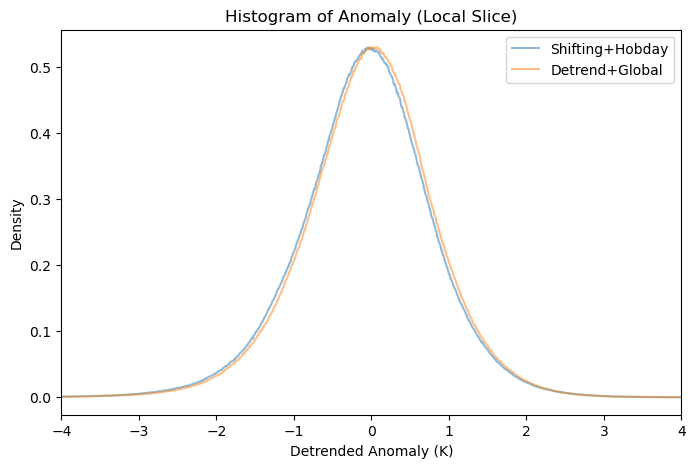

In [15]:
bins = np.arange(-4, 4, 0.01)
lat_slice = slice(35, 40)
lon_slice = slice(310,340)

dat_shifting = extremes_ds_shifting['dat_detrend'].sel(lat=lat_slice, lon=lon_slice).data
dat_detrend = extremes_ds_detrend['dat_detrend'].sel(lat=lat_slice, lon=lon_slice).data

hist_shifting, _ = da.histogram(dat_shifting, bins=bins, density=True)
hist_detrend, _ = da.histogram(dat_detrend, bins=bins, density=True)

hist_shifting_computed, hist_detrend_computed = dask.compute(hist_shifting, hist_detrend)

plt.figure(figsize=(8, 5))
plt.plot(bins[:-1], hist_shifting_computed, label='Shifting+Hobday', alpha=0.5)
plt.plot(bins[:-1], hist_detrend_computed, label='Detrend+Global', alpha=0.5)
plt.xlabel('Detrended Anomaly (K)')
plt.ylabel('Density')
plt.title('Histogram of Anomaly (Local Slice)')
plt.xlim(-4, 4)
plt.legend()
plt.show()

### Global Extreme Event Frequency

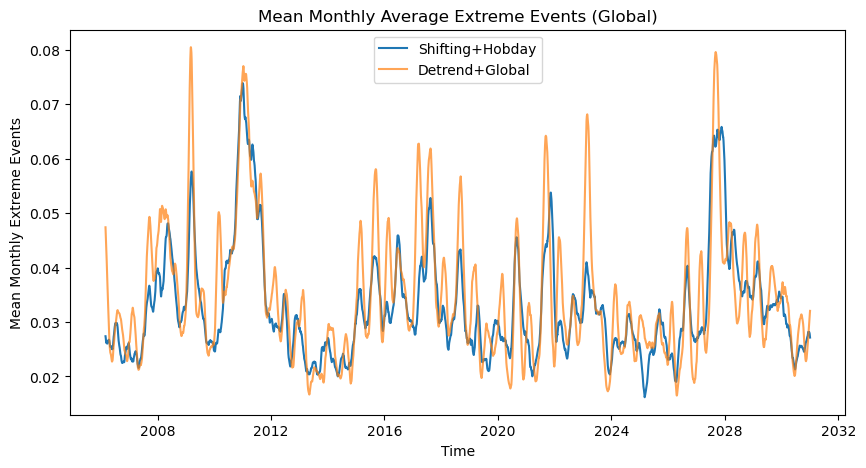

In [ ]:
monthly_shifting = extremes_ds_shifting['extreme_events'].mean(dim=['lat', 'lon']).rolling(time=60).mean()
monthly_detrend = extremes_ds_detrend['extreme_events'].mean(dim=['lat', 'lon']).rolling(time=60).mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_shifting['time'], monthly_shifting, label='Shifting+Hobday')
plt.plot(monthly_detrend['time'], monthly_detrend, label='Detrend+Global', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Mean Monthly Extreme Events')
plt.title('Mean Monthly Average Extreme Events (Global)')
plt.legend()
plt.show()

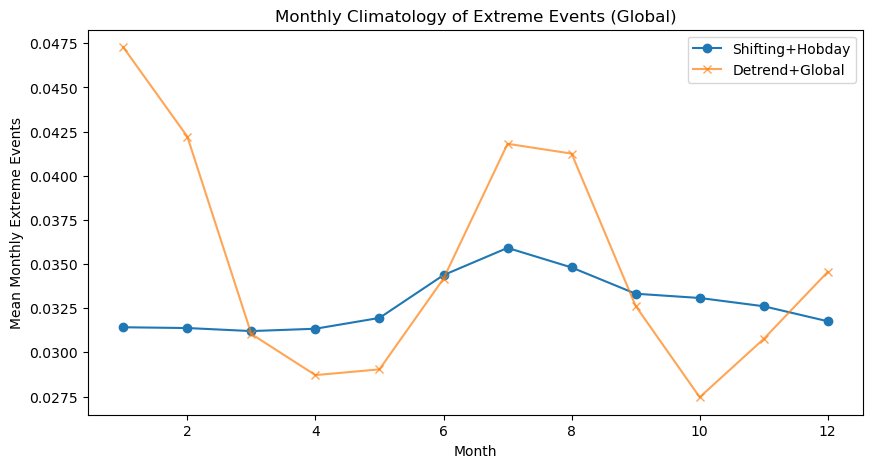

In [10]:
monthly_shifting_clim = extremes_ds_shifting['extreme_events'].mean(dim=['lat', 'lon']).groupby('time.month').mean(dim='time')
monthly_detrend_clim = extremes_ds_detrend['extreme_events'].mean(dim=['lat', 'lon']).groupby('time.month').mean(dim='time')

plt.figure(figsize=(10, 5))
monthly_shifting_clim.plot(label='Shifting+Hobday', marker='o')
monthly_detrend_clim.plot(label='Detrend+Global', marker='x', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Mean Monthly Extreme Events')
plt.title('Monthly Climatology of Extreme Events (Global)')
plt.legend()
plt.show()